# DenseNet161
#### image size 128; Augmented

In [0]:
import mini_library as ml
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

## Part 1: Read data

In [2]:
!sudo apt-get update
!sudo apt-get install wget
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7" -O data.zip && rm -rf /tmp/cookies.txt
from zipfile import ZipFile
with ZipFile('./data.zip', 'r') as zipObj:
    print("Started unzipping... \n")
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
    print("Files unziped sucessfully\n")
!ls

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [92.1 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sou

In [3]:
train_data, train_labels = ml.load_data('./train')

train_mean = train_data.mean(axis=(0,2,3))
train_std = train_data.std(axis=(0,2,3))
print('\n mean and std:','\n',train_mean,'\n',train_std)

Data loading:
 0.0 % complete
 5.0 % complete
 10.0 % complete
 15.0 % complete
 20.0 % complete
 25.0 % complete
 30.0 % complete
 35.0 % complete
 40.0 % complete
 45.0 % complete
 50.0 % complete
 55.0 % complete
 60.0 % complete
 65.0 % complete
 70.0 % complete
 75.0 % complete
 80.0 % complete
 85.0 % complete
 90.0 % complete
 95.0 % complete
Data loading complete.
Data size:	 torch.Size([100000, 3, 64, 64])
Label size:	  torch.Size([100000])

 mean and std: 
 tensor([0.4802, 0.4481, 0.3975]) 
 tensor([0.2770, 0.2691, 0.2821])


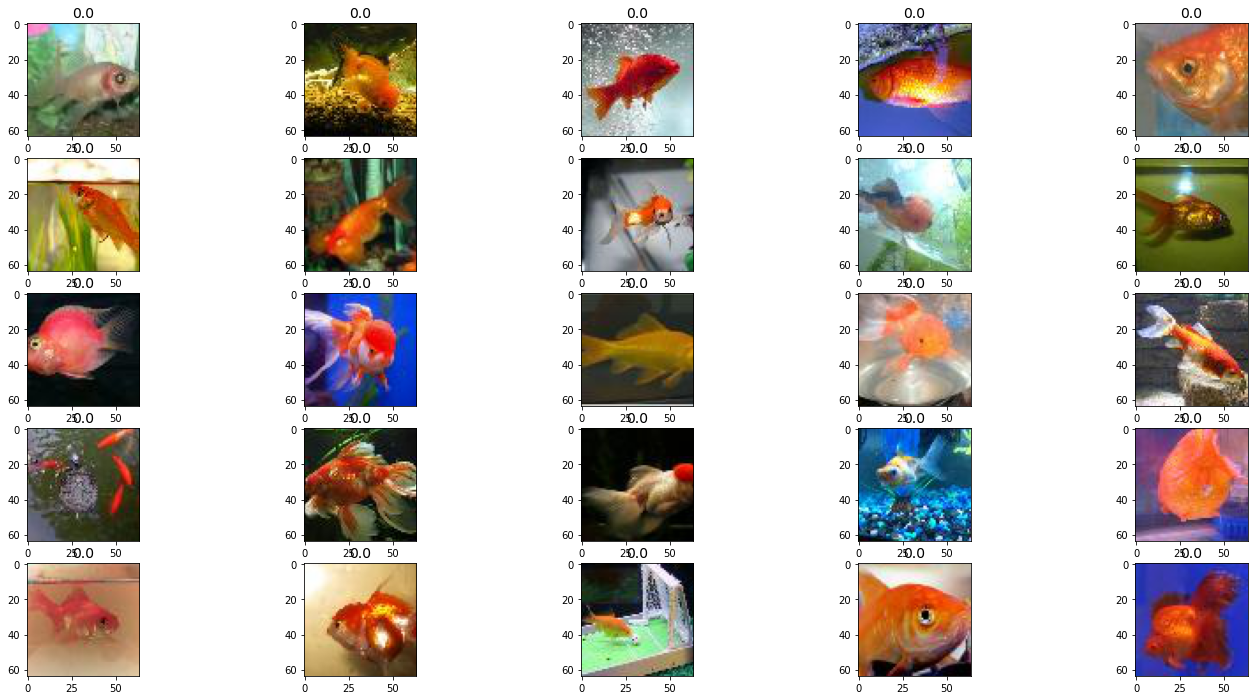

In [4]:
ml.plot_25_from(train_data, train_labels)

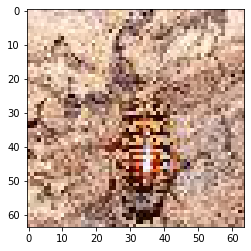

In [5]:
#shuffle split the data with a train-validation split of 90%-10%

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_data, train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = train_data[indices[0]].float(), train_labels[indices[0]].long()
X_val, y_val = train_data[indices[1]].float(), train_labels[indices[1]].long()
plt.imshow(X_train[1].permute(1, 2, 0))

#  Part 2: Data Augmentation


In [0]:
# data augmentation used:
  # Resize image
  # Random horizontal flip
  # Random Rotations by up to 10 Degrees;
  # Shifting up-down, left-right by 5 pixels
  # Adding Gaussian Noise with small mean and var

new_dimension = 128

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(new_dimension),
    transforms.RandomCrop(new_dimension, padding=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std), # this is the mean and std of RGB channels of CIFAR10 training dataset, after dividing by 255
]) 


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(new_dimension),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])


In [0]:
# Load dataset

batch_size = 64
test_batch_size = 1000

# intiate custom datasets for augmented data
custom_train_dset = ml.CustomImageTensorDataset(X_train, y_train, transform=train_transform)
costum_val_dset = ml.CustomImageTensorDataset(X_val, y_val, transform=test_transform)

custom_train_loader = DataLoader(custom_train_dset, batch_size=batch_size, shuffle=True, num_workers=0)
custom_validation_loader = DataLoader(costum_val_dset, batch_size=test_batch_size, shuffle=False, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data is of size  torch.Size([3, 128, 128])
sample mean after transform:  [-0.17458783 -0.15428407 -0.12219496]
sample std after transform:  [1.0112453  0.99840915 0.95073783]


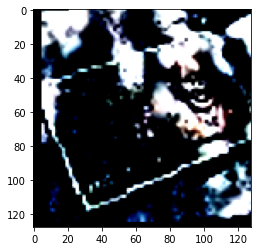

In [8]:
for X, y in custom_train_loader:
    print('data is of size ', X[0].size())
    print('sample mean after transform: ', X.numpy().mean(axis=(0,2,3)))
    print('sample std after transform: ', X.numpy().std(axis=(0,2,3)))
    plt.imshow(X[1].permute(1, 2, 0))
    break


# Part 3: Retrain Pre-training model

#### Here, pre-trained DenseNet161 from torchvision.models is chosen 


In [9]:
import torch.nn as nn
import torchvision
# load the densenet161 pre-trained model
model = torchvision.models.densenet161(pretrained=True)

# modify the last classifier to fit our dataset
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 200)

#instantiate criterion, optimizer and scheduler
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.25, weight_decay = 5e-6)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


In [10]:
# for te purpose of this example we just run one epoch
model = ml.train_model(model, {'train':custom_train_loader, 'val':custom_validation_loader},criterion, optimizer, exp_lr_scheduler,
                       num_epochs=1)

Cuda installed! Running on GPU!
Epoch 0/0
----------
train Loss: 1.9929 Acc: 0.5774
val Loss: 0.1148 Acc: 0.0817

 Training complete in 30m 6s
Best val Acc: 0.081667


# Part 4: Save model

In [0]:
# save model

model_save_name = 'Densenet_128_with_augment_final.pth'
path = F"./{model_save_name}" 
torch.save(model.state_dict(), path)

# Part 5: Export Predictions

In [0]:
test_file_path = './test'
transform = transforms.Compose([
    transforms.Resize(new_dimension),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)])

ml.get_prediction_csv(model, test_file_path, transform)